# Hierarchical Model for Batting Averages

In [17]:
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv("./data/BattingAverage.csv")

Convert position and player indexes to Python format - start from zero 

In [6]:
data["PriPosNumber"] = data["PriPosNumber"] - 1
data["PlayerNumber"] = data["PlayerNumber"] - 1

Create positions lookup table - i.e. indexes/names

In [174]:
positions = data[["PriPos", "PriPosNumber"]].drop_duplicates().sort_values("PriPosNumber")
positions.head()

,PriPos,PriPosNumber
0,Pitcher,0
13,Catcher,1
4,1st Base,2
2,2nd Base,3
11,3rd Base,4


In [175]:
players = data[["Player", "PlayerNumber"]].drop_duplicates().sort_values("PlayerNumber")
players.head()

,Player,PlayerNumber
0,Fernando Abad,0
1,Bobby Abreu,1
2,Tony Abreu,2
3,Dustin Ackley,3
4,Matt Adams,4


# Model Description
<img src="./img/model_desc.PNG" width="700" align="left">

In [8]:
pos_index = data.PriPosNumber.values
n_pos = data.PriPosNumber.nunique() # number of modelled positions
n_players = data.PlayerNumber.nunique() # number of players
y = data.Hits.values
N = data.AtBats.values

In [9]:
with pm.Model() as model:
    omega0 = pm.Beta("omega0", 1, 1)
    kappa0_minus_two = pm.Gamma("kappa0_minus_two", 0.01, 0.01)
    kappa0 = pm.Deterministic("kappa0", kappa0_minus_two + 2)
    
    omega = pm.Beta("omega", omega0*(kappa0 - 2) + 1, (1 - omega0)*(kappa0 - 2) + 1, shape=n_pos)
    kappa_minus_two = pm.Gamma("kappa_minus_two", 0.01, 0.01, shape=n_pos)
    kappa = pm.Deterministic("kappa", kappa_minus_two + 2)
    
    theta = pm.Beta(
        "theta", 
        omega[pos_index]*(kappa[pos_index] - 2) + 1, (1 - omega[pos_index])*(kappa[pos_index] - 2) + 1, shape=n_players)
    y_lh = pm.Binomial("y", p=theta, observed=y, n=N)

In [10]:
with model:
    trace = pm.sample(11000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_minus_two, omega, kappa0_minus_two, omega0]
Sampling 4 chains: 100%|██████████| 46000/46000 [11:31<00:00, 26.43draws/s] 
The number of effective samples is smaller than 10% for some parameters.


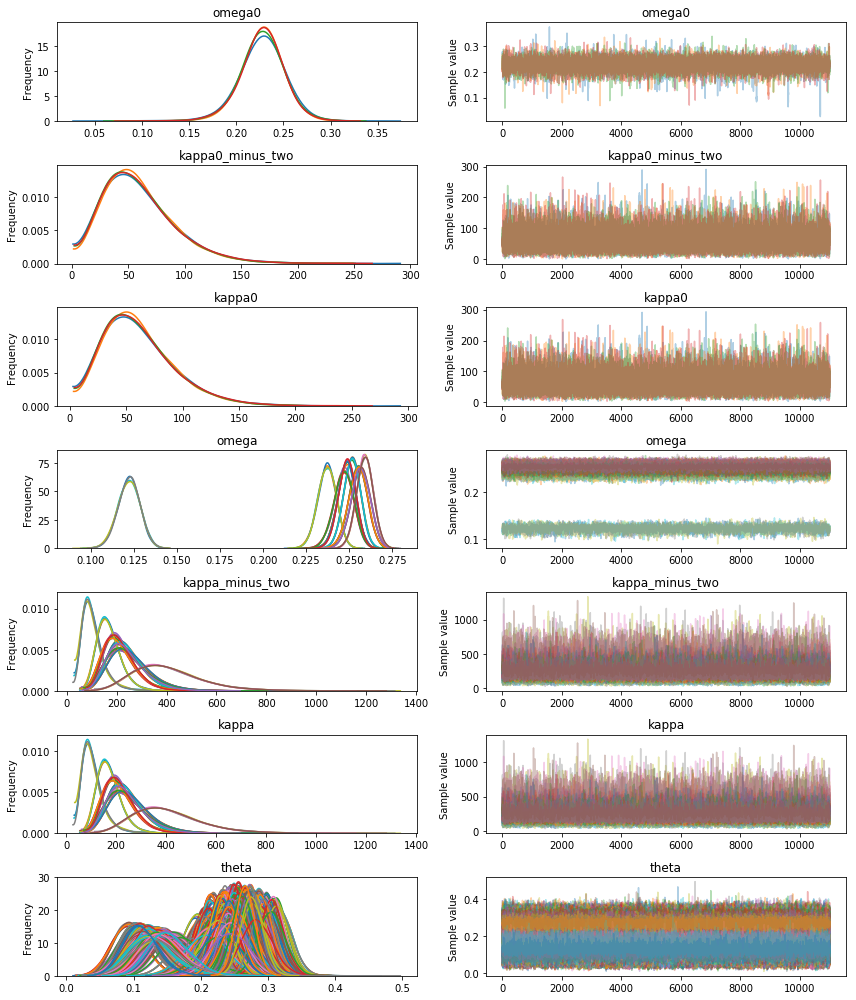

In [188]:
pm.traceplot(trace);

In [11]:
omegas = pd.DataFrame(trace["omega"], columns=positions.PriPos.values)
thetas = pd.DataFrame(trace["theta"], columns=players.Player.values)

## Distribution of batting averages by position 

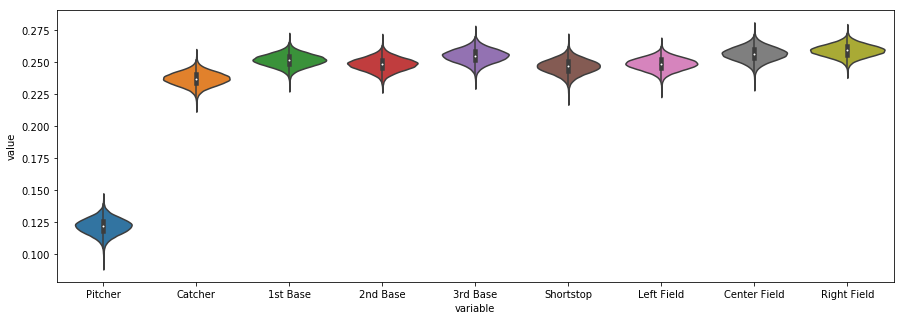

In [210]:
f, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(x="variable", y="value", data=pd.melt(omegas), ax=ax)

## Comparisons

In [179]:
def plot_sample(trace, ax, label):
    hdi = pm.stats.hpd(trace, alpha=0.05)
    sns.distplot(trace, ax=ax,  axlabel = label, kde=False)
    ax.plot(
        (hdi[0], hdi[1]), (0, 0), 
        linewidth=5, color="r", 
        label="95% HDI: {} - {}".format(np.round(hdi[0], 3), np.round(hdi[1], 3)));
    ax.legend(loc="lower left")

In [192]:
def plot_diffs(trace_1, trace_2, label_1, label_2):
    f, axs = plt.subplots(2, 2, figsize=(10, 8))
    plot_sample(trace_1, axs[0][0], label_1)
    plot_sample(trace_1 - trace_2, axs[0][1], "{} - {}".format(label_1, label_2))
    scatter_plot_ax = axs[1][0]
    sns.scatterplot(x=trace_1, y=trace_2, ax=scatter_plot_ax)
    scatter_plot_ax.set_xlabel(label_1)
    scatter_plot_ax.set_ylabel(label_2)
    
    min_trace_1 = trace_1.min()
    min_trace_2 = trace_2.min()
    max_trace_1 = trace_1.max()
    max_trace_2 = trace_2.max()
    global_min = min(min_trace_1, min_trace_2)
    global_max = max(max_trace_1, max_trace_2)
    scatter_plot_ax.plot((global_min, global_max), (global_min, global_max), c="r", ls="--");

    #scatter_plot_ax.set_xlim((min_trace_1, max_trace_1))
    #scatter_plot_ax.set_ylim((min_trace_2, max_trace_2))
    
    plot_sample(trace_2, axs[1][1], label_2)

### Pitchers / Catchers

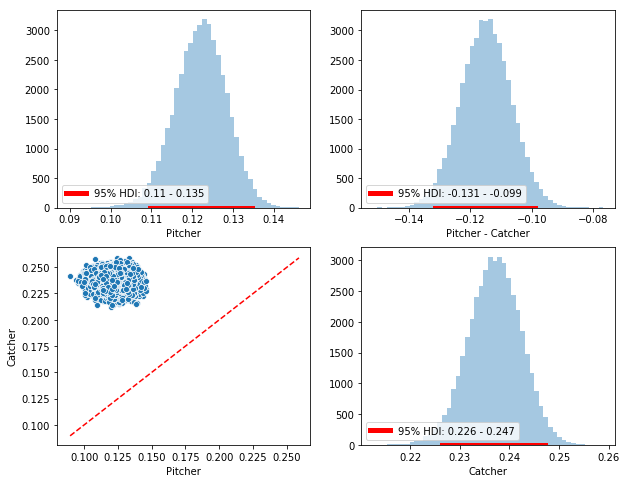

In [193]:
plot_diffs(omegas["Pitcher"], omegas["Catcher"], "Pitcher", "Catcher")

### Catchers / 1st Bases

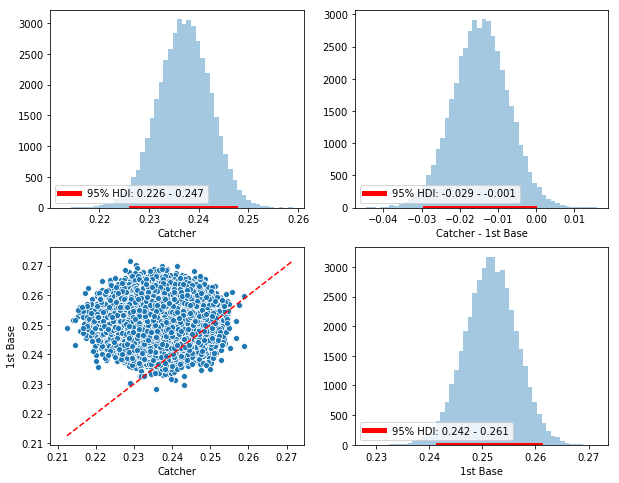

In [194]:
plot_diffs(omegas["Catcher"], omegas["1st Base"], "Catcher", "1st Base")

### Kyle Blanks / Bruce Chen

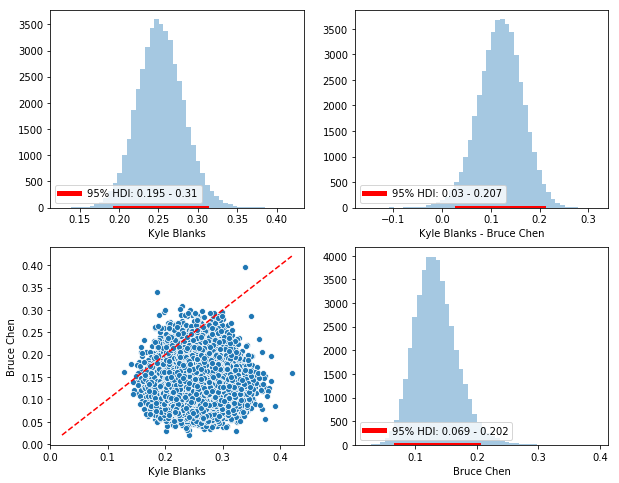

In [195]:
plot_diffs(thetas["Kyle Blanks"], thetas["Bruce Chen"], "Kyle Blanks", "Bruce Chen")